В этом модуле мы будем решать задачу классификации: 

классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Скачать набор данных можно здесь. С подробным описанием датасета и столбцов таблицы ознакомьтесь в источнике.

In [41]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
 
from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
plt.style.use('seaborn') # стиль отрисовки seaborn
%matplotlib inline

In [42]:
water_data = pd.read_csv('data/water_potability.zip')
water_data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

In [43]:
TARGET_FEATURE = 'Potability'

In [44]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [45]:
colums_with_null = (water_data.isnull().mean() * 100).round(2)
colums_with_null


ph                 14.99
Hardness            0.00
Solids              0.00
Chloramines         0.00
Sulfate            23.84
Conductivity        0.00
Organic_carbon      0.00
Trihalomethanes     4.95
Turbidity           0.00
Potability          0.00
dtype: float64

Получу список признаков в которых есть пропуски 

In [46]:
null_columns = list(colums_with_null[colums_with_null > 0].index)
null_columns

['ph', 'Sulfate', 'Trihalomethanes']

Итак, у нас отсутствует 

около 15 % информации о кислотности воды (ph), 

около 24 % — о содержании сульфатов (Sulfate) 

около 5 % — о тригалометанах (Trihalomethanes). 

Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). 

Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [47]:
# В цикле заполняю пропуски медианным значением в разрезе целевого признака
for col in null_columns:
    # Заполняем пропуски
    water_data[col] = water_data[col].fillna(water_data.groupby(TARGET_FEATURE)[col].transform('median'))

Теперь проблема пропусков устранена. 

Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [48]:
X = water_data.drop(TARGET_FEATURE, axis=1)
y = water_data[TARGET_FEATURE]

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

In [49]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [51]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик
print(f'Train hold-out accuracy: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'Valid hold-out accuracy: {metrics.accuracy_score(y_valid, y_valid_pred):.2f}') 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [52]:
# разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [53]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


# K-FOLD

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

In [54]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []

# Организуем цикл для кросс-валидации (используем весь набор данных)
# train_index — индексы тренировочной выборки
# valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y):
    # Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
    # Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    
    # Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [55]:
print(train_metrics)
print(val_metrics)

[0.8213740458015267, 0.8168637924456315, 0.8096146508966043, 0.8057993132392217, 0.8031285768790538]
[0.7713414634146342, 0.7984732824427481, 0.76793893129771, 0.7282442748091603, 0.766412213740458]


Для агрегированной оценки рассчитаем среднее значение метрик:

In [56]:
print(f'Train k-fold mean accuracy: {np.mean(train_metrics):.2f}')
print(f'Valid k-fold mean accuracy: {np.mean(val_metrics):.2f}')

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.77


### На самом весь приведённый выше код можно значительно сократить,
### если использовать специальную функцию для кросс-валидации

In [57]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
 
# Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=kf, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

cv_metrics

{'fit_time': array([0.05002069, 0.04599524, 0.04200673, 0.04453301, 0.04254222,
        0.0430069 , 0.04256916, 0.05301046, 0.04199767, 0.04876494]),
 'score_time': array([0.00199533, 0.002002  , 0.00200081, 0.00200224, 0.00184059,
        0.00224161, 0.00700045, 0.00200558, 0.00100207, 0.00400257]),
 'test_score': array([0.7804878 , 0.75304878, 0.73780488, 0.72256098, 0.7804878 ,
        0.76829268, 0.74923547, 0.76146789, 0.77370031, 0.76146789]),
 'train_score': array([0.80257802, 0.81648575, 0.82157395, 0.80122117, 0.79918589,
        0.80936228, 0.80196677, 0.7965412 , 0.7972194 , 0.8138352 ])}

In [58]:
mean_train = np.mean(cv_metrics['train_score'])
mean_test = np.mean(cv_metrics['test_score'])

In [59]:
print(f'Train k-fold mean accuracy: {mean_train:.2f}')
print(f'Test k-fold mean accuracy: {mean_test:.2f}')

Train k-fold mean accuracy: 0.81
Test k-fold mean accuracy: 0.76


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

## LEAVE-ONE-OUT

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер  равняется размеру всей выборки , где  — количество примеров (строк в таблице).

Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [60]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42 # генератор случайных чисел  
)
 
# Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
# Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X.iloc[:500], # матрица наблюдений X
    y=y.iloc[:500], # вектор ответов y
    cv=loo, # кросс-валидатор
    scoring='accuracy', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


### Дисбаланс выборки

In [61]:
water_data[TARGET_FEATURE].value_counts(normalize=True)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

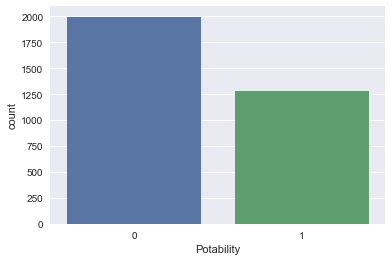

In [62]:
sns.countplot(data=water_data, x=TARGET_FEATURE)
plt.show()

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [63]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, 

в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [64]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. 

In [65]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


### Задание 3.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:

In [66]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, # количество объектов
    n_features=2, # количество признаков
    n_informative=2, # количество информативных признаков
    n_redundant=0, # количество неинформативных признаков
    n_classes=2, # количество классов
    weights=[1, 0.2], # пропорции классов
    random_state=40 # генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)

In [67]:
y.value_counts(normalize=True)

0    0.9
1    0.1
dtype: float64

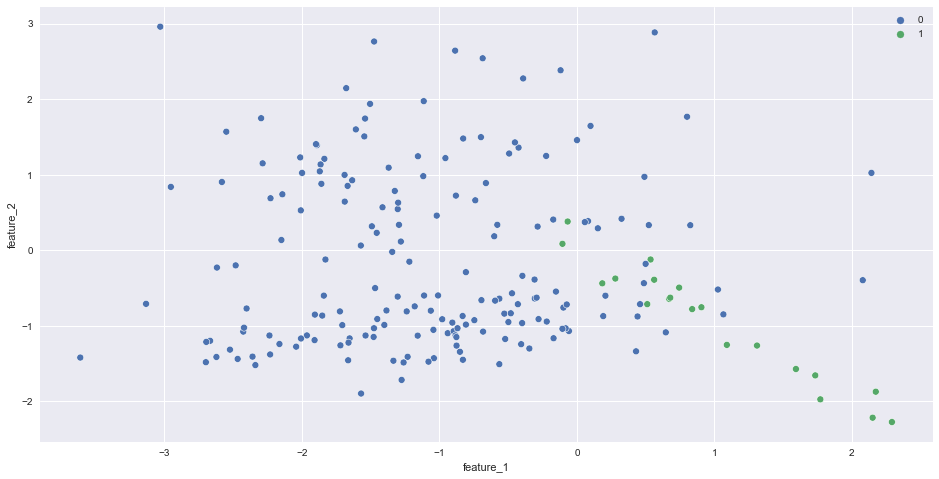

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y)
plt.show()

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

In [69]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

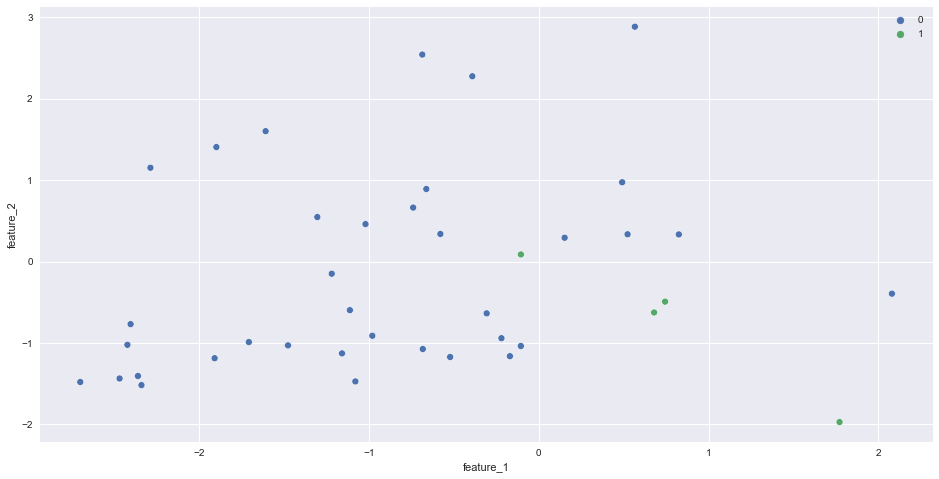

In [70]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid)
plt.show()

### Задание 3.5
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [71]:
from sklearn import linear_model

In [72]:
lr = linear_model.LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [73]:
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



### Задание 3.6 (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии.

Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

In [74]:
# Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    # Генерируем координатную сетку из всех возможных значений для признаков
    # Glucose изменяется от x1_min = 44 до x2_max = 199, 
    # BMI - от x2_min = 18.2 до x2_max = 67.1
    # Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    
    # Вытягиваем каждый из массивов в вектор-столбец - reshape(-1, 1)
    # Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    
    # Предсказывает вероятность для всех точек на координатной сетке
    # Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    
    # Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    
    # Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    
    # Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    
    # Рисуем разделяющую плоскость - линия, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    
    # Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    
    # Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    
    # Даем графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    
    # Смещаем легену в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_1416\521854114.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


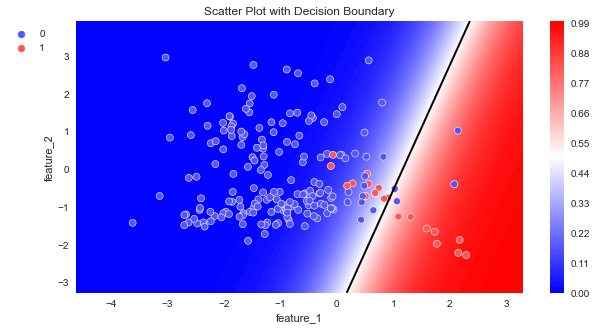

In [75]:
plot_probabilities_2d(X, y, lr)

### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов.

Для того чтобы задать веса классам по приведённым выше формулам, 

достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [76]:
# Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', # критерий информативности
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, # минимальное число объектов в листе
    random_state=42, # генератор случайных чисел
    class_weight='balanced' # веса классов
)

# Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



### Задание 3.7
Обучите модель логистической регрессии на тренировочной выборке, уставив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [77]:
lr = linear_model.LogisticRegression(class_weight='balanced')

lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [78]:
y_train_pred = lr.predict(X_train)
y_valid_pred = lr.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_1416\521854114.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


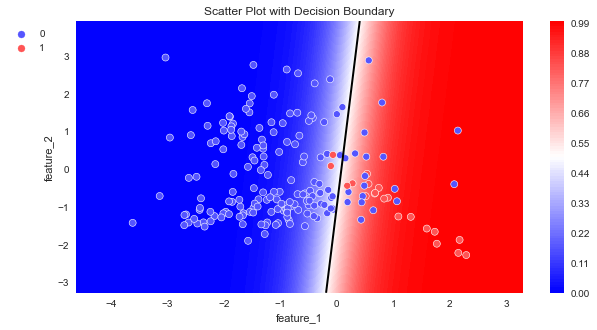

In [79]:
plot_probabilities_2d(X, y, lr)

F1 для класса 0 упала, но при этом выросла для класса 1.

На разделяющей поверхности видно, что мы теперь меньше упускаем обеъкты класса 1.

### Задание 3.11
Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.